# Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torchvision
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
import torch.nn.functional as F

import gc
from time import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed = 42

# Helper Functions

In [2]:
def breaker():
    print("\n" + 50*"-" + "\n")

def head(x, no_of_ele=5):
    print(x[:no_of_ele])

# Data Handling

**Data Loading**

In [3]:
images = np.load("../input/rccl-ds-384/images_1x384x384.npy")
labels = np.load("../input/rccl-ds-384/labels.npy")

start_time = time()
tr_images, va_images, tr_labels, va_labels = train_test_split(images, labels, test_size=0.2,
                                                              shuffle=True, random_state=0)

breaker()
print("Time Taken to Load Data : {:.2f} seconds".format(time() - start_time))

del images, labels, start_time

breaker()
print("Garbage Collected : {}".format(gc.collect()))
breaker()


--------------------------------------------------

Time Taken to Load Data : 2.94 seconds

--------------------------------------------------

Garbage Collected : 36

--------------------------------------------------



**Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(this, X=None, y=None, transform=None, mode="train"):
        this.mode = mode
        this.transform = transform
        this.X = X
        if mode == "train":
            this.y = y
                 
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        img = this.transform(this.X[idx])
        if this.mode == "train":
            return img, torch.FloatTensor(this.y[idx])
        else:
            return img

# CNN Configuration and Setup

**Config**

In [5]:
class CFG():
    tr_batch_size = 64
    # va_batch_size = 128
    ts_batch_size = 64
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    in_channels = 1
    OL = 11
    
    def __init__(this, filter_sizes=[64, 128, 256, 512], HL=[2048], epochs=50, n_folds=5):
        this.filter_sizes = filter_sizes
        this.HL = HL
        this.epochs = epochs
        this.n_folds = n_folds

**Setup**

In [6]:
class CNN(nn.Module):
    def __init__(this, in_channels=1, filter_sizes=None, HL=None, OL=None, use_DP=True, DP=0.50):
        
        super(CNN, this).__init__()
        
        this.use_DP = use_DP
        
        this.DP_ = nn.Dropout(p=DP)
        this.MP_ = nn.MaxPool2d(kernel_size=2)
        
        this.CN1 = nn.Conv2d(in_channels=in_channels, out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1)
        this.BN1 = nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5)
        
        this.CN2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1)
        this.BN2 = nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5)
        
        this.CN3 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)
        
        this.CN4 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN4 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        
        this.CN5 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN5 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        
        this.CN6 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN6 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        
        this.CN7 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN7 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        
        this.FC1 = nn.Linear(in_features=filter_sizes[3] * 3 * 3, out_features=HL[0])
        this.FC2 = nn.Linear(in_features=HL[0], out_features=OL)
        
    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
    
    def getStepLR(this, optimizer=None, step_size=5, gamma=0.1):
        return optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)
    
    def getMultiStepLR(this, optimizer=None, milestones=None, gamma=0.1):
        return optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma)
    
    def getPlateauLR(this, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=1e-8, verbose=True)
    
    def forward(this, x):
        if this.use_DP:
            x = F.relu(this.MP_(this.BN1(this.CN1(x))))
            x = F.relu(this.MP_(this.BN2(this.CN2(x))))
            x = F.relu(this.MP_(this.BN3(this.CN3(x))))
            x = F.relu(this.MP_(this.BN4(this.CN4(x))))
            x = F.relu(this.MP_(this.BN5(this.CN5(x))))
            x = F.relu(this.MP_(this.BN6(this.CN6(x))))
            x = F.relu(this.MP_(this.BN7(this.CN7(x))))
            
            x = x.view(x.shape[0], -1)
            
            x = F.relu(this.DP_(this.FC1(x)))
            x = this.FC2(x)
            
            return x
        else:
            x = F.relu(this.MP_(this.BN1(this.CN1(x))))
            x = F.relu(this.MP_(this.BN2(this.CN2(x))))
            x = F.relu(this.MP_(this.BN3(this.CN3(x))))
            x = F.relu(this.MP_(this.BN4(this.CN4(x))))
            x = F.relu(this.MP_(this.BN5(this.CN5(x))))
            x = F.relu(this.MP_(this.BN6(this.CN6(x))))
            x = F.relu(this.MP_(this.BN7(this.CN7(x))))
            
            x = x.view(x.shape[0], -1)
            
            x = F.relu(this.FC1(x))
            x = this.FC2(x)
            
            return x

**Train Function**

In [7]:
def fit_(model=None, optimizer=None, scheduler=None, epochs=None,
         early_stopping_patience=5,
         trainloader=None, validloader=None,
         criterion=None, device=None,
         verbose=None, path=None):
    
    breaker()
    print("Training")
    breaker()
    
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    DLS = {"train" : trainloader, "valid" : validloader}
    
    Losses = []
    Accuracies = []
    
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : 0.0, "valid" : 0.0}
        
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            lossPerPass = []
            
            for X, y in DLS[phase]:
                X, y = X.to(device), y.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = criterion(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)
        
        """if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            torch.save(model.state_dict(), "./Epoch_{}.pt".format(e+1))
            early_stopping_steps = 0
            bestLossEpoch = e+1
        else:
            early_stopping_steps += 1
            if early_stopping_steps > early_stopping_patience:
                print("Early Stopping at Epoch {}".format(e+1))"""
        
        torch.save(model.state_dict(), "./Epoch_{}.pt".format(e+1))
        
        if scheduler:
            scheduler.step()
            # scheduler.step(epochLoss["valid"])
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            torch.save(model.state_dict(), "./Epoch_{}.pt".format(e+1))
            bestLossEpoch = e+1
            
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))

    breaker()
    print("-----> Best Validation Loss at Epoch {}".format(bestLossEpoch))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time()-start_time)/60))
    breaker()
    print("Training Complete")
    breaker()

    return Losses, bestLossEpoch

**Training**

In [8]:
cfg = CFG(filter_sizes=[64, 128, 256, 512], HL=[2048], epochs=30, n_folds=5)

tr_transforms = transforms.Compose([transforms.ToTensor(), ])
va_transforms = transforms.Compose([transforms.ToTensor(), ])

tr_data_setup = DS(X=tr_images, y=tr_labels, transform=tr_transforms, mode="train")
va_data_setup = DS(X=va_images, y=va_labels, transform=va_transforms, mode="train")

tr_data = DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(seed))
va_data = DL(va_data_setup, batch_size=cfg.tr_batch_size, shuffle=False)

del tr_data_setup, va_data_setup

breaker()
print("Garbage Collected : {}".format(gc.collect()))

torch.manual_seed(seed)

model = CNN(filter_sizes=cfg.filter_sizes, HL=cfg.HL, OL=cfg.OL, use_DP=True, DP=0.5).to(cfg.device)
optimizer = model.getOptimizer(lr=1e-3, wd=1e-5)

# scheduler = model.getStepLr(optimizer=optimizer, step_size=5, gamma=0.1)
# scheduler = model.getMultiStepLR(optimizer=optimizer, milestones=[10, 20, 30, 40], gamma=0.1)
# scheduler = model.getPlateauLR(optimizer=optimizer, patience=5, eps=1e-8)

Losses, bestEpoch = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=cfg.epochs, early_stopping_patience=5,
                         trainloader=tr_data, validloader=va_data, criterion=nn.BCEWithLogitsLoss(), device=cfg.device,
                         verbose=True)


--------------------------------------------------

Garbage Collected : 20

--------------------------------------------------

Training

--------------------------------------------------

Epoch: 1 | Train Loss: 0.30161 | Valid Loss: 0.26876 | Time: 345.28 seconds
Epoch: 2 | Train Loss: 0.26949 | Valid Loss: 0.29499 | Time: 344.03 seconds
Epoch: 3 | Train Loss: 0.25227 | Valid Loss: 0.25788 | Time: 344.39 seconds
Epoch: 4 | Train Loss: 0.24031 | Valid Loss: 0.39220 | Time: 344.46 seconds
Epoch: 5 | Train Loss: 0.23326 | Valid Loss: 0.25917 | Time: 344.46 seconds
Epoch: 6 | Train Loss: 0.22771 | Valid Loss: 0.25427 | Time: 344.63 seconds
Epoch: 7 | Train Loss: 0.22295 | Valid Loss: 0.23326 | Time: 344.58 seconds
Epoch: 8 | Train Loss: 0.21635 | Valid Loss: 0.21926 | Time: 344.15 seconds
Epoch: 9 | Train Loss: 0.20926 | Valid Loss: 0.22202 | Time: 343.87 seconds
Epoch: 10 | Train Loss: 0.20259 | Valid Loss: 0.20212 | Time: 344.33 seconds
Epoch: 11 | Train Loss: 0.19360 | Valid Loss: 0.

**Loss Plot**

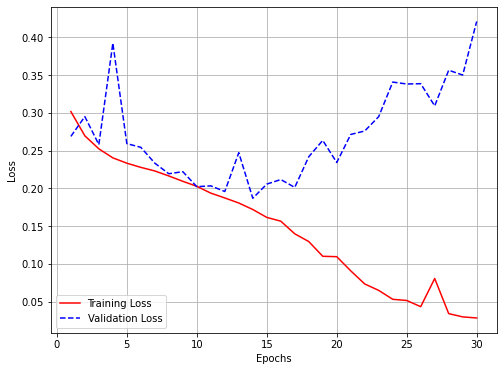

In [9]:
LT = []
LV = []

for i in range(len(Losses)):
    LT.append(Losses[i]["train"])
    LV.append(Losses[i]["valid"])

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LT))], LT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LV))], LV, "b--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()